In [63]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms

import pandas as pd
import numpy as np 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix


import graphviz

In [4]:

url = r'C:\Users\Anton\Documents\Anton_Gollbo\Skolarbete\STS4\SML\data\training_data.csv'
url2 = r'C:\Users\Anton\Documents\Anton_Gollbo\Skolarbete\STS4\SML\data\songs_to_classify.csv'
df_songs_training = pd.read_csv(url, dtype={'ID': str}).dropna().reset_index(drop=True)
df_songs_test = pd.read_csv(url2, dtype={'ID': str}).dropna().reset_index(drop=True)



# 0. Always predicting Person to like a given song
### Will give us some reference value to "compete" against

In [60]:
df_model = df_songs_training.copy()
x = df_model.drop(columns=['label'])
y = df_model['label']

prediction = np.ones(y.shape[0])

always_like_prediction_acc = accuracy_score(y,prediction)
print(always_like_prediction_acc)

0.6026666666666667


# 1. Model using scaling and dummy variables on time signature


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib

C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib

C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib

C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib

C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib

C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
C:\Users\Anton\Anaconda3\lib

0.6444444444444445 42


,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,1,3,4,5
0,0.88500,0.366,352000,0.1390,0.913000,7,0.0725,-19.978,1,0.0390,139.478,4,0.310,0,0,1,0
1,0.12400,0.863,236293,0.5760,0.000000,5,0.1430,-5.687,0,0.2390,132.054,4,0.832,0,0,1,0
2,0.18400,0.631,219160,0.6990,0.000000,9,0.1080,-7.625,0,0.0284,128.433,4,0.707,0,0,1,0
3,0.01080,0.800,201840,0.8940,0.437000,6,0.0285,-7.346,0,0.0400,138.480,4,0.967,0,0,1,0
4,0.00440,0.788,228000,0.6730,0.000005,9,0.0755,-9.232,1,0.1990,99.979,4,0.478,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.82300,0.635,89067,0.3380,0.000434,9,0.2210,-8.078,1,0.5120,168.163,3,0.736,0,1,0,0
746,0.03250,0.544,238493,0.5000,0.000004,11,0.1090,-8.253,1,0.0260,93.621,4,0.177,0,0,1,0
747,0.99200,0.525,226293,0.0633,0.905000,9,0.1050,-23.072,1,0.0497,71.855,4,0.297,0,0,1,0
748,0.54500,0.365,237267,0.5200,0.000000,9,0.1110,-6.520,1,0.0331,106.152,4,0.400,0,0,1,0


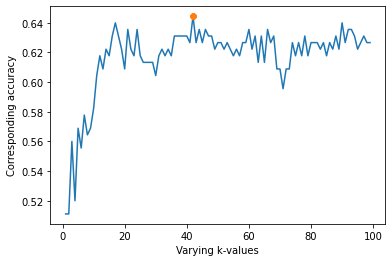

In [14]:
df_model = df_songs_training
scaler = StandardScaler()
features = [["acousticness"]]

#Create x and y variable
dummy_key = pd.get_dummies(df_model["time_signature"])
df_model = pd.concat([df_model, dummy_key], axis = 1)

iteration_accuracies = []

x = df_model.drop(columns=['label'])
y = df_model['label']#Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)#Training the model
best_accuracy = 0
best_k = 0
K = np.arange(1,100)

for k in K:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)#Predict testing set
    y_pred = knn.predict(x_test)#Check performance using accuracy
    
    iteration_accuracy = accuracy_score(y_test,y_pred)
    iteration_accuracies.append(iteration_accuracy)
    
    if iteration_accuracy> best_accuracy:
        best_accuracy = iteration_accuracy
        best_k = k
        
print(best_accuracy, best_k)

plt.plot(K, iteration_accuracies)
plt.plot(best_k,best_accuracy , marker="8")
plt.xlabel("Varying k-values")
plt.ylabel("Corresponding accuracy")
x

# 2. Model using feature selection using tree based estimators ExtraTreesClassifier


In [50]:
df_model = df_songs_training.copy()
x = df_model.drop(columns=['label'])
y = df_model['label']#Split data

iteration_accuracy_list = []
best_iteration_accuracies = {}

dict_keyword = "n_estimators_"


for num in range(5, 16):
    # "ExtraTreesClassifier" is chosen for features selection is chosen 
    clf = ExtraTreesClassifier(n_estimators=num, criterion = "entropy")
    clf = clf.fit(x, y)
    clf.feature_importances_  

    top_features_from_fs = SelectFromModel(clf, prefit=True)
    model_using_fs = model.transform(x)
    x_train, x_test, y_train, y_test = train_test_split(model_using_fs, y, test_size=0.3)

    best_accuracy = 0
    best_k = {}
    K = np.arange(1,100)

    for k in K:
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(x_train, y_train)#Predict testing set
        y_pred = knn.predict(x_test)#Check performance using accuracy

        iteration_accuracy = accuracy_score(y_test,y_pred)
        iteration_accuracy_list.append(iteration_accuracies)


        if iteration_accuracy > best_accuracy:
            best_accuracy = iteration_accuracy
            best_iteration_accuracies[f"n_estimators_{num}"] = [iteration_accuracy]
            best_k[num] = k

    print(best_accuracy, best_k)

C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7733333333333333 {5: 45}


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7866666666666666 {6: 61}


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8311111111111111 {7: 22}


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8044444444444444 {8: 7}


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7866666666666666 {9: 43}


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7955555555555556 {10: 19}


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8266666666666667 {11: 9}


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8266666666666667 {12: 7}


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8088888888888889 {13: 1}


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8 {14: 6}


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.7644444444444445 {15: 3}


# 3. Cross validation of K-NN

C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


The best K-value is given at k =  5 which results in the accuracy:  0.788


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


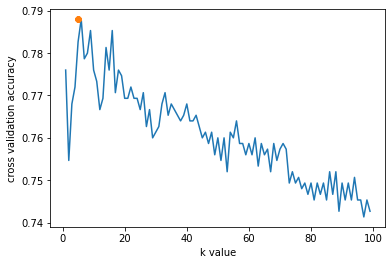

In [79]:
url = r'data\training_data.csv'
url2 = r'data\songs_to_classify.csv'
songTraining = pd.read_csv(url, dtype={'ID': str}).dropna().reset_index(drop=True)
songTest = pd.read_csv(url2, dtype={'ID': str}).dropna().reset_index(drop=True)

df_model = songTraining.copy()
#Split data into x and y
x = df_model.drop(columns=['label'])
y = df_model['label']

#Perform feature selection using ExtraTreesClassifier with 10 classes
clf = ExtraTreesClassifier(n_estimators=10, criterion = "entropy")
#Fit data according to selected important features
clf = clf.fit(x, y)
clf.feature_importances_  
#Create a model based on the feature selection 
model = SelectFromModel(clf, prefit=True)
X = model.transform(x)
#Define a cross validation object with 10 splits
crossVal = skl_ms.KFold(n_splits=10, shuffle = True)
newsplit = crossVal.split(X)
#
K = np.arange(1,100)

misclassifications = np.zeros(len(K))

for train_index, val_index in crossVal.split(X):
    X_train, X_validation = X[train_index], X[val_index]
    y_train, y_validation = y[train_index], y[val_index]
    scaler = StandardScaler()
    scaler.fit(X_train)
    scaler.transform(X_train)
    scaler.transform(X_validation)
    
    for j,k in enumerate(K):
        kNNModel = skl_nb.KNeighborsClassifier(n_neighbors = k)
        kNNModel.fit(X_train,y_train.values.ravel())
        kNNpredict = kNNModel.predict(X_validation)
        kNNpredict = kNNpredict.reshape(kNNpredict.size,1)
        misclassifications[j] += accuracy_score(y_validation,kNNpredict)
        
misclassifications /= 10 
plt.plot(K, misclassifications)
plt.plot(np.argmax(misclassifications),max(misclassifications), marker="8")
plt.xlabel("k value")
plt.ylabel("cross validation accuracy")
best_k = np.argmax(misclassifications)
print("The best K-value is given at k = ", np.argmax(misclassifications), "which results in the accuracy: ",  max(misclassifications))

X_songTest = songTest
X_songTest_new = X_songTest[["acousticness", "danceability", "energy", "loudness", "speechiness"]]

kNNModel = skl_nb.KNeighborsClassifier(n_neighbors = best_k)
kNNModel.fit(X, y)

kNN_predict = kNNModel.predict(X_songTest_new)


In [80]:
best_k = np.argmax(misclassifications)

In [81]:
X_songTest = songTest
X_songTest_new = X_songTest[["acousticness", "danceability", "energy", "loudness", "speechiness"]]

kNNModel = skl_nb.KNeighborsClassifier(n_neighbors = best_k)
kNNModel.fit(X, y)

kNN_predict = kNNModel.predict(X_songTest_new)

C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
knnPredictFinal = kNNpredict

In [83]:
kNNpredict

array([[0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [85]:

knn_str_prediction = str(kNNpredict)

knn_str_prediction = knn_str_prediction.replace("[", "")
knn_str_prediction = knn_str_prediction.replace("]", "")
knn_str_prediction = knn_str_prediction.replace("\n", "")
knn_str_prediction = knn_str_prediction.replace(" ", "")
knn_str_prediction

'011110001001101111111010001111011111110111111010111011001111011110001111111'

# 4. Multilayer perceptron test


In [32]:
df_model = songTraining.copy()

df_model = songTraining.copy()
x = df_model.drop(columns=['label'])
y = df_model['label']#Split data

clf = ExtraTreesClassifier(n_estimators=10, criterion = "entropy")
clf = clf.fit(x, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X = model.transform(x)

accuracies = []
mlps = []
iterations = np.arange(1,10);

for i in iterations:
    X_train, X_validation, y_train, y_validation = skl_ms.train_test_split(X,y, test_size = 0.3)
    mlp = MLPClassifier(hidden_layer_sizes=(10,5),max_iter=5000)
    mlps.append(mlp.fit(X_train, y_train))
    predictions = mlp.predict(X_validation)
    iteration_accuracy = accuracy_score(y_validation,predictions)
    accuracies.append(iteration_accuracy)

print(accuracies)






[0.8577777777777778, 0.8133333333333334, 0.8133333333333334, 0.8, 0.8266666666666667, 0.8088888888888889, 0.8266666666666667, 0.8044444444444444, 0.8355555555555556]


In [36]:
print(mlps[0], accuracies[0])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 5), learning_rate='constant',
              learning_rate_init=0.001, max_iter=5000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False) 0.8577777777777778


C:\Users\Anton\Anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Average accuracy: 0.8146666666666667 Highest accuracy:  0.88 Lowest accuracy:  0.7466666666666667 STD:  0.03975480404233487
Accuracies:  [0.7466666666666667, 0.8133333333333334, 0.8133333333333334, 0.7733333333333333, 0.88, 0.8666666666666667, 0.8133333333333334, 0.7866666666666666, 0.8, 0.8533333333333334]


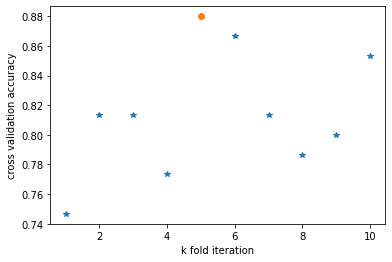

In [73]:
df_model = songTraining.copy()
x = df_model.drop(columns=['label'])
y = df_model['label']#Split data

clf = ExtraTreesClassifier(n_estimators=10, criterion = "entropy")
clf = clf.fit(x, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X = model.transform(x)
splits = 10
misclassifications = np.zeros(splits)
accuracies_new = []
layer_size = (10,5)
i = []
ii = 0
crossVal = skl_ms.KFold(n_splits=splits,shuffle = True)
newsplit = crossVal.split(X)

best_model = 0
best_acc = 0


for train_index, val_index in crossVal.split(X):
    ii += 1
    i.append(ii)
    X_train, X_validation = X[train_index], X[val_index]
    y_train, y_validation = y[train_index], y[val_index]
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    mlpModel = MLPClassifier(hidden_layer_sizes= layer_size, max_iter = 5000)
    mlpModel.fit(X_train, y_train)
    mlpPredict = mlpModel.predict(X_validation)
    iteration_accuracy = accuracy_score(y_validation,mlpPredict)
    accuracies_new.append(iteration_accuracy)
    
    if iteration_accuracy > best_acc:
        best_acc = iteration_accuracy
        best_model = mlpModel   


print("Average accuracy:", np.mean(accuracies_new), "Highest accuracy: ", max(accuracies_new), "Lowest accuracy: ", min(accuracies_new), "STD: " , np.std(accuracies_new))
print("Accuracies: ", accuracies_new)


best_model_predict = best_model.predict(X)
best_model_accuracy = accuracy_score(y, best_model_predict)
confusion_matrix(y, best_model_predict)


best_index = np.argmax(accuracies_new)
plt.plot(i, accuracies_new,"*")
plt.plot(best_index+1, accuracies_new[best_index],marker="8")
plt.xlabel("k fold iteration")
plt.ylabel("cross validation accuracy")
plt.show()



In [77]:
clf.decision_path(x)

(<750x5550 sparse matrix of type '<class 'numpy.int64'>'
 	with 96198 stored elements in Compressed Sparse Row format>,
 array([   0,  567, 1114, 1697, 2176, 2775, 3328, 3907, 4500, 5035, 5550],
       dtype=int32))